In [1]:
# Imports 


import sys
# setting path
sys.path.append('../core')
import os
#os.environ["VECLIB_MAXIMUM_THREADS"] = "10"

from sklearn.decomposition import PCA

#bread and butter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

#machine learning library
import sklearn
import sklearn.manifold
import sklearn.cluster
import sklearn.decomposition

#statistics
import scipy
from scipy.stats import rankdata, norm

import numba
from numba import jit, njit

from tqdm import tqdm
import copy
import cvxpy as cp

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
#import numpy as tnp
import warnings
warnings.filterwarnings('ignore')

# import dfply
# from dfply import *
# import ray
# import datetime


import os
import warnings
warnings.filterwarnings("ignore")

#import torch
#torch.cuda.is_available()
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import scipy

import confound_mdp
import confound_ope
import confound_env
import copy
import pickle

from subspace import *
from clustering import *
from emalg import *
from helpers import *

%matplotlib inline
plt.style.use('matplotlibrc')

2023-01-23 17:40:04.303603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:40:04.413294: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-23 17:40:04.899221: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-01-23 17:40:04.899251: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
d_min = np.minimum(getN_sa(dataset[dataset[:,:,2]==0], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==0]),
           getN_sa(dataset[dataset[:,:,2]==1], nStates, nActions, burnin=0, reshape=False)/len(dataset[dataset[:,:,2]==1]))


NameError: name 'dataset' is not defined

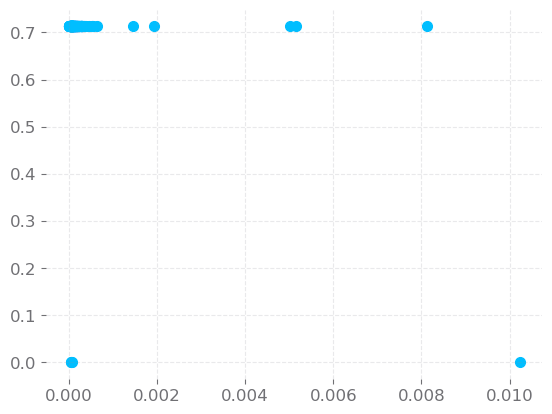

In [34]:
plt.scatter(d_min.flatten(), np.linalg.norm((P[0])-(P[1]), axis=-1).flatten())

In [ ]:
diagnostic = False
horizons = [20, 30, 40, 50, 60, 70, 80, 90, 100]#, 120, 140, 160, 180, 200]
#horizons = [180]

trials = 30
import multiprocessing


clusterAccsTrials = []
clusterAccsNoProjsTrials = []
classAccsTrials = []
hardClustEMAccsTrials = []
softClustEMAccsTrials = []
hardEMAccsTrials = []
softEMAccsTrials = []

for trial in range(trials):
    clusterAccs = []
    clusterAccsNoProjs = []
    modelEstims = []
    classAccs = []
    hardClustEMs = []
    hardClustEMAccs = []
    softClustEMs = []
    softClustEMAccs = []
    hardEMs = []
    hardEMAccs = []
    softEMs = []
    softEMAccs = []
    
    start_seed = trial*multiprocessing.cpu_count()
    print("Trial", trial, "with start seed", start_seed)

    for horizon in horizons:
        print("Current Horizon is:", horizon)

        ###GRIDWORLD###
    
        pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                        confound_weight=0.6, small=False, soft=True)
        pi_b[0] = pi_b.mean(0)
        pi_b[1] = pi_b.mean(0)

        mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

        nStates = P.shape[2]
        nActions = P.shape[1]

        ###GRIDWORLD###

        dataset = getSamplesMultiProc(1000, mdp, pi_b, horizon, start_seed=start_seed, iid=False)

         # behavior value
        print("value of pi_b")
        returns = confound_mdp.calc_returns(dataset, gamma, horizon)
        print(returns.mean())
    

        stateactions = dataset[:, :, [0, 1]]
        memorder = 'C'

        if memorder == 'F':
            stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
        else:
            stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
        states = (dataset[:,:,0]).astype(int)
        actions = (dataset[:,:,1]).astype(int)
        currstates = dataset[:,:,[0,1]].astype(int)
        confounders = dataset[:,:,2].astype(int)
        labels = confounders[:,0].astype(int)
        nextstates = dataset[:,:,3].astype(int)

        L = 2
        K = 2
        #S = nStates*nActions
        #N = len(threes)


        ########SUBSPACE ESTIMATION########

        sadim = nStates*nActions
        spdim = nStates
        omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
        omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
        onehotsa = np.eye(sadim)[stateactions]
        #onehotsaflat = copy.deepcopy(onehotsa)
        onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
        onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
        sz = int(onehotsa.shape[0]/3)

        eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')

        #########CLUSTERING#########

        device = "/GPU:0"

        hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                         onehotsp[sz:,omegaone,:]), 
                                  geth(onehotsa[sz:,omegatwo,:,:], 
                                       onehotsp[sz:,omegatwo,:])], dtype=np.float32)

        statmns = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
        if diagnostic:
            clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()
            clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                       lo=0, hi=0.0005, step=0.000025) #0,0.01, 0.0001
            plt.show()

        statNoProjs = computeStat(hs, 
                          eigvecsa, numpy=False, smalldata=False, device=device, proj=False)

        clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')

        clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < 0.0001).astype(int), n_clusters=2,
                                                         assign_labels='kmeans')
    
        
        
        
        permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])])
        if diagnostic:
            print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))
        clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                        np.mean(clusterlabs != confounders[sz:, 0])]))

        clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                        np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))

        ########MODEL ESTIMATION#########
        Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                             states[sz:,:], 
                             actions[sz:,:], 
                             nextstates[sz:,:],
                            K=K, nStates=nStates, nActions=nActions, hard=True)
        modelEstims.append(Phat_ksa)


        ########CLASSIFICATION#########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)
        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                               nextstates[:sz,:], piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        if diagnostic:
            print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                    np.mean(labels[:sz] != subspaceClass)][permutation])
        classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])


        ########EM ALGORITHM########
        priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
        piclust = getPolicyEstim(states[sz:], actions[sz:], 
                                 K, nStates, nActions, preds=clusterlabs, hard=True)

        startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
        maxapos = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                           prior=priorclass, startweights = startweights, labs=True)
        mleprobs = classify(Phat_ksa, states, actions, 
                               nextstates, piclust, reg=1, 
                            prior=priorclass, startweights = startweights, labs=False)
        if diagnostic:
            print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])

        # HARD EM
        expectclass, modelestimclass, loglikclass = em(maxapos, 
                                Phat_ksa, states, actions, 
                            nextstates, labels=labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, max_iter=100,
                                                   permute=False, permutation=permutation,
                                                   checkin=1, hard=True, verbose=False)
        hardClustEMs.append([expectclass, modelestimclass, loglikclass])
        hardClustEMAccs.append(np.max([np.mean(labels == expectclass), np.mean(labels != expectclass)]))

        # SOFT EM
        normprobs = np.exp(mleprobs-np.max(mleprobs))
        regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
        expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                    Phat_ksa, states, actions, 
                                nextstates, labels, 
                                K=2, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 1, permute=False,
                                permutation=permutation, checkin=1, hard=False, verbose=False)
        softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
        softClustEMAccs.append(np.max([np.mean(labels == expectclasssoft.argmax(0)),
                                np.mean(labels != expectclasssoft.argmax(0))]))

        #############BASE EM###############

        labelsem = []
        logliksem = []
        for i in tqdm(range(30)):
            randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
            randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                      K, nStates, nActions, hard=True)
            randlabs, randmodel, loglikrand = em(randlabs, randmodel,
               states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
            labelsem.append(randlabs)
            logliksem.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Hard EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
            plt.show()
        hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
        hardEMs.append([labelsem, logliksem])

        labelsemsoft = []
        logliksemsoft = []
        for i in tqdm(range(30)):
            unifs = np.random.uniform(size=len(dataset))
            randlabsoft = np.vstack([unifs, 1-unifs])
            randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                      K, nStates, nActions, hard=False)
            randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
           states, actions, nextstates, labels, 
                                K=K, nStates=nStates, nActions=nActions,
                                prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
            labelsemsoft.append(randlabsoft)
            logliksemsoft.append(loglikrand)
        if diagnostic:
            plt.figure(figsize=(12,7))
            plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                        logliksemsoft)
            print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
            plt.ticklabel_format(style='plain',useOffset=False)
            plt.xlabel('Accuracy')
            plt.ylabel('Log-likelihood')
            plt.title('Randomly Initialized Soft EM Algorithm')
            plt.show()
            plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
            plt.show()
        softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
        softEMs.append([labelsemsoft, logliksemsoft])
        
    clusterAccsTrials.append(clusterAccs)
    clusterAccsNoProjsTrials.append(clusterAccsNoProjs)
    classAccsTrials.append(classAccs)
    hardClustEMAccsTrials.append(hardClustEMAccs)
    softClustEMAccsTrials.append(softClustEMAccs)
    hardEMAccsTrials.append(hardEMAccs)
    softEMAccsTrials.append(softEMAccs)

Trial 0 with start seed 0
Current Horizon is: 20
value of pi_b
-1.0695422369486682


2023-01-23 17:40:27.135229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-23 17:40:27.137199: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 17:40:27.137292: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-23 17:40:27.137342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at

Current Horizon is: 30
value of pi_b
-1.5486396180004034


100%|██████████| 30/30 [00:06<00:00,  4.42it/s]


Current Horizon is: 40
value of pi_b
-1.7841622907876984


100%|██████████| 30/30 [00:07<00:00,  3.82it/s]


Current Horizon is: 50
value of pi_b
-2.139136817122347


100%|██████████| 30/30 [00:09<00:00,  3.33it/s]


Current Horizon is: 60
value of pi_b
-2.472334976154326


100%|██████████| 30/30 [00:10<00:00,  2.98it/s]


Current Horizon is: 70
value of pi_b
-2.713155797927031


100%|██████████| 30/30 [00:11<00:00,  2.69it/s]


Current Horizon is: 80
value of pi_b
-2.8916472868175283


100%|██████████| 30/30 [00:12<00:00,  2.42it/s]


Current Horizon is: 90
value of pi_b
-3.1695663378121446


100%|██████████| 30/30 [00:13<00:00,  2.22it/s]


Current Horizon is: 100
value of pi_b
-3.476886461647142


100%|██████████| 30/30 [00:14<00:00,  2.04it/s]


Trial 1 with start seed 32
Current Horizon is: 20
value of pi_b
-1.2081600086938535


100%|██████████| 30/30 [00:05<00:00,  5.18it/s]


Current Horizon is: 30
value of pi_b
-1.4820315545053422


100%|██████████| 30/30 [00:06<00:00,  4.38it/s]


Current Horizon is: 40
value of pi_b
-1.8220049822848208


100%|██████████| 30/30 [00:08<00:00,  3.74it/s]


Current Horizon is: 50
value of pi_b
-2.143949122857712


  3%|▎         | 1/30 [00:00<00:08,  3.26it/s]

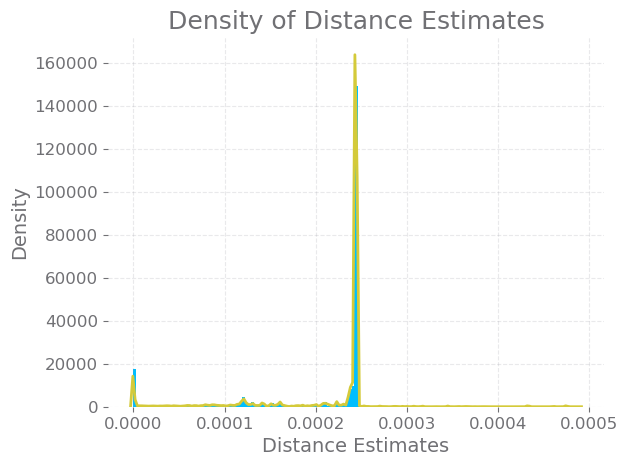

<Figure size 640x480 with 0 Axes>

In [79]:
import seaborn as sns
#plt.figure(figsize=(16,9))
plt.hist(statmns.flatten(), bins=200, density=True)#[1]
#plt.hist(statmns.flatten(), bins=onehotsaclust.shape[0], density=True)[2]
sns.kdeplot(statmns.flatten(), bw_adjust=0.2)
#plt.title('')
plt.xlabel('Distance Estimates')
plt.title('Density of Distance Estimates')
plt.show()
plt.savefig('figs/distDens.png')

100%|██████████| 20/20 [00:01<00:00, 16.35it/s]


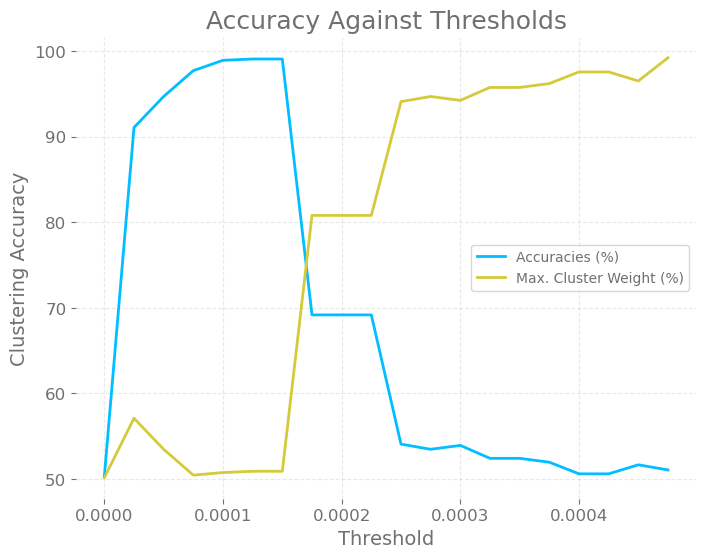

In [78]:
clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
                           lo=0, hi=0.0005, step=0.000025, figsize=(8,6))
plt.ylabel('Clustering Accuracy')
plt.title('Accuracy Against Thresholds')
plt.savefig('figs/clustAccs.png')

0.7461693548387096
0.7726814516129032
0.8810483870967742


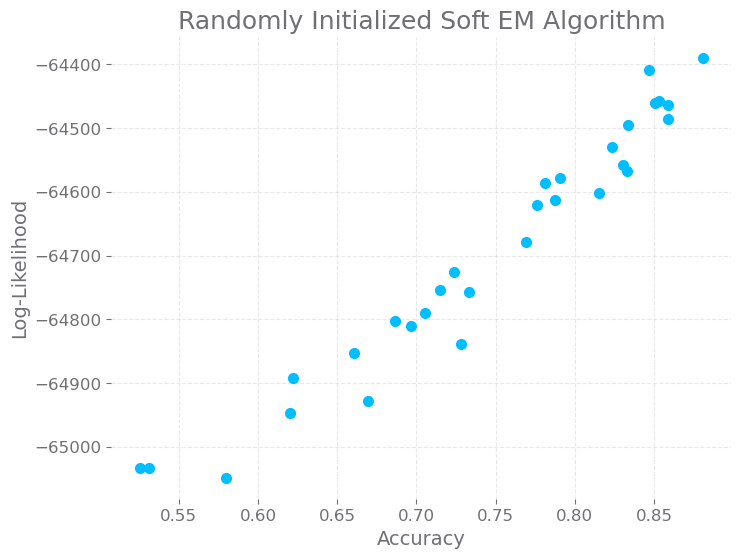

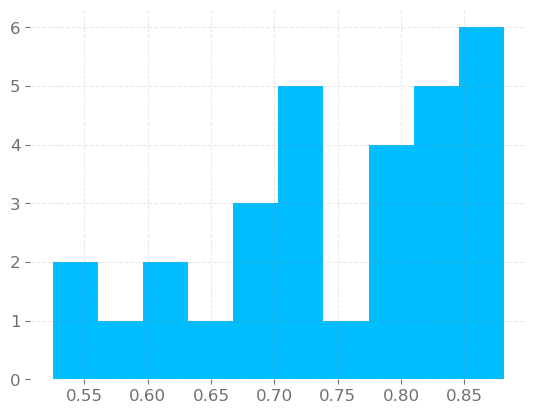

In [80]:
plt.figure(figsize=(8,6))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-Likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.show()
plt.savefig('figs/softEM.png')
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

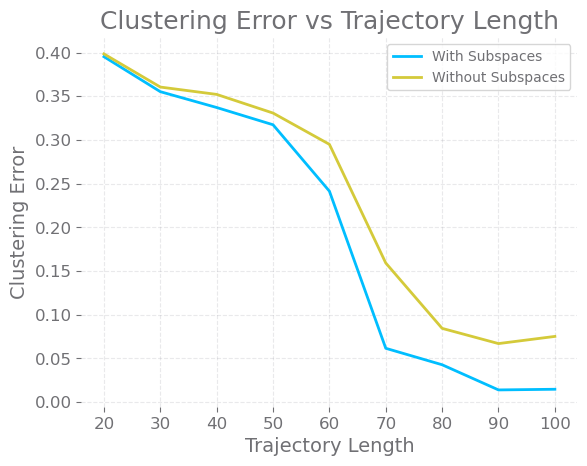

In [77]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(clusterAccsTrials),0), label='With Subspaces')
plt.plot(horizons, 1-np.mean(np.array(clusterAccsNoProjsTrials),0), label='Without Subspaces')
plt.ylabel("Clustering Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Error vs Trajectory Length")
plt.legend()
plt.savefig('figs/clust.png')

Text(0.5, 1.0, 'Hard EM First Step Error vs Trajectory Length')

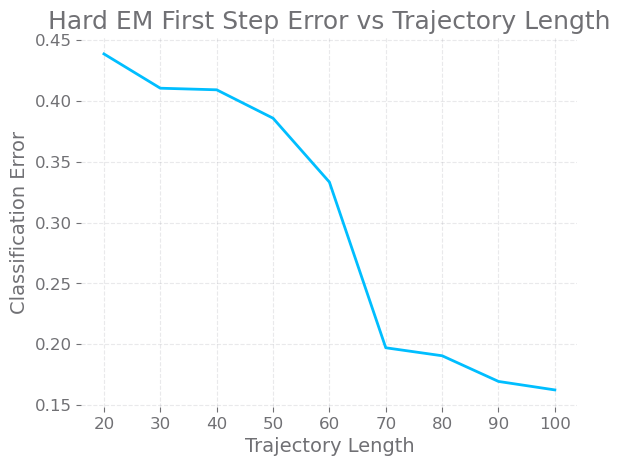

In [88]:
#plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.mean(np.array(classAccsTrials),0))
plt.ylabel("Classification Error")
plt.xlabel("Trajectory Length")
plt.title("Hard EM First Step Error vs Trajectory Length")
#plt.legend()

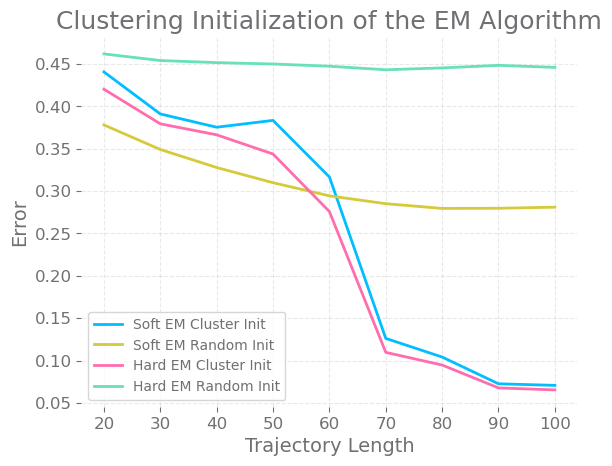

In [87]:
#plt.figure(figsize=(16,9))
'''
plt.plot(horizons, 1-np.median(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.median(np.array(hardEMAccsTrials),0),
        label='Hard EM')
'''  
plt.plot(horizons, 1-np.mean(np.array(softClustEMAccsTrials),0),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(softEMAccsTrials),0),
        label='Soft EM Random Init')
plt.plot(horizons, 1-np.mean(np.array(hardClustEMAccsTrials),0),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.mean(np.array(hardEMAccsTrials),0),
        label='Hard EM Random Init')
plt.ylabel("Error")
plt.xlabel("Trajectory Length")
plt.title("Clustering Initialization of the EM Algorithm")
plt.legend()
plt.savefig('figs/emClust.png')

horizons = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
#horizons = [180]
clusterAccs = []
clusterAccsNoProjs = []
modelEstims = []
classAccs = []
hardClustEMs = []
hardClustEMAccs = []
softClustEMs = []
softClustEMAccs = []
hardEMs = []
hardEMAccs = []
softEMs = []
softEMAccs = []


for horizon in horizons:
    print("Current Horizon is:", horizon)
    
    #########SETUP#########

    
    ###GRIDWORLD###
    
    pi_b, P, R, x_dist, u_dist, gamma = confound_env.gridworld_opetools(horizon = horizon, slip = 0.04, 
                                                                    confound_weight=0.6, small=False, soft=True)
    pi_b[0] = pi_b.mean(0)
    pi_b[1] = pi_b.mean(0)
    
    mdp = confound_mdp.ConfoundMDP(P, R, x_dist, u_dist, gamma)

    nStates = P.shape[2]
    nActions = P.shape[1]
    
    ###GRIDWORLD###
    
    dataset = getSamplesMultiProc(1000, mdp, pi_b, horizon, iid=False)
    
     # behavior value
    print("value of pi_b")
    returns = confound_mdp.calc_returns(dataset, gamma, horizon)
    print(returns.mean())
    
    
    stateactions = dataset[:, :, [0, 1]]
    memorder = 'C'

    if memorder == 'F':
        stateactions = (dataset[:,:,0] + dataset[:,:,1]*nStates).astype(int) #we code (S x A) as s + a|S|, 0,16,32,48 1,17,33,49
    else:
        stateactions = (dataset[:,:,0]*nActions + dataset[:,:,1]).astype(int)
    states = (dataset[:,:,0]).astype(int)
    actions = (dataset[:,:,1]).astype(int)
    currstates = dataset[:,:,[0,1]].astype(int)
    confounders = dataset[:,:,2].astype(int)
    labels = confounders[:,0].astype(int)
    nextstates = dataset[:,:,3].astype(int)

    L = 2
    K = 2
    #S = nStates*nActions
    #N = len(threes)
    
    
    ########SUBSPACE ESTIMATION########
    
    sadim = nStates*nActions
    spdim = nStates
    omegaone = np.array([i for i in range(int(horizon/4), 2*int(horizon/4))])
    omegatwo = np.array([i for i in range(3*int(horizon/4), horizon)])
    onehotsa = np.eye(sadim)[stateactions]
    #onehotsaflat = copy.deepcopy(onehotsa)
    onehotsa = onehotsa.reshape((onehotsa.shape[0], onehotsa.shape[1], nStates, nActions), order=memorder)
    onehotsp = np.eye(np.max(nextstates)+1)[nextstates]
    sz = int(onehotsa.shape[0]/3)
    
    eigvalsa, eigvecsa = getEig(onehotsa[:sz], onehotsp[:sz], omegaone, omegatwo, K, wt=True, smalldata=False, device='/GPU:0')
    
    #########CLUSTERING#########
    
    device = "/GPU:0"

    hs = np.array([geth(onehotsa[sz:,omegaone,:,:], 
                                     onehotsp[sz:,omegaone,:]), 
                              geth(onehotsa[sz:,omegatwo,:,:], 
                                   onehotsp[sz:,omegatwo,:])], dtype=np.float32)
    
    statmns = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=True)
    
    #clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
    #               lo=0, hi=0.00012, step=0.000005) #0,0.01, 0.0001
    #clusterDiagnostics(statmns, K=K, labels=confounders[sz:, 0],
    #               lo=0, hi=0.0005, step=0.000025)
    plt.show()
    
    statNoProjs = computeStat(hs, 
                      eigvecsa, numpy=False, smalldata=False, device=device, proj=False)
    
    #clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
    #               lo=0, hi=0.00012, step=0.000005) #0,0.01, 0.0001
    clusterDiagnostics(statNoProjs, K=K, labels=confounders[sz:, 0],
                   lo=0, hi=0.0005, step=0.000025)
    plt.show()
    
    #clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.00004).astype(int), n_clusters=2,
    #                                                 assign_labels='kmeans')
    clusterlabs = sklearn.cluster.spectral_clustering((statmns < 0.0001).astype(int), n_clusters=2,
                                                     assign_labels='kmeans')
    
    clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < 0.00004).astype(int), n_clusters=2,
                                                     assign_labels='kmeans')
    clusterlabsNoProjs = sklearn.cluster.spectral_clustering((statNoProjs < 0.0001).astype(int), n_clusters=2,
                                                     assign_labels='kmeans')
    
    permutation = np.argmax([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])])
    print(permutation, np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])]))
    clusterAccs.append(np.max([np.mean(clusterlabs == confounders[sz:, 0]), 
                    np.mean(clusterlabs != confounders[sz:, 0])]))
    
    clusterAccsNoProjs.append(np.max([np.mean(clusterlabsNoProjs == confounders[sz:, 0]), 
                    np.mean(clusterlabsNoProjs != confounders[sz:, 0])]))
    
    ########MODEL ESTIMATION#########
    Phat_ksa = getModelEstim(clusterlabs.astype(int), 
                         states[sz:,:], 
                         actions[sz:,:], 
                         nextstates[sz:,:],
                        K=K, nStates=nStates, nActions=nActions, hard=True)
    modelEstims.append(Phat_ksa)
    
    
    ########CLASSIFICATION#########
    priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
    piclust = getPolicyEstim(states[sz:], actions[sz:], 
                             K, nStates, nActions, preds=clusterlabs, hard=True)
    startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
    subspaceClass = classify(Phat_ksa, states[:sz,:], actions[:sz,:], 
                           nextstates[:sz,:], piclust, reg=1, 
                       prior=priorclass, startweights = startweights, labs=True)
    print('Subspace Classification accuracy:', [np.mean(labels[:sz] == subspaceClass), 
                                                np.mean(labels[:sz] != subspaceClass)][permutation])
    classAccs.append([np.mean(labels[:sz] == subspaceClass), np.mean(labels[:sz] != subspaceClass)][permutation])
    
    
    ########EM ALGORITHM########
    priorclass = np.bincount(clusterlabs)/len(clusterlabs) 
    piclust = getPolicyEstim(states[sz:], actions[sz:], 
                             K, nStates, nActions, preds=clusterlabs, hard=True)

    startweights = getStartWeights(states[sz:], clusterlabs, K, nStates)
    maxapos = classify(Phat_ksa, states, actions, 
                           nextstates, piclust, reg=1, 
                       prior=priorclass, startweights = startweights, labs=True)
    mleprobs = classify(Phat_ksa, states, actions, 
                           nextstates, piclust, reg=1, 
                        prior=priorclass, startweights = startweights, labs=False)
    print('MAP estimate overall accuracy:', [np.mean(labels == maxapos), np.mean(labels != maxapos)][permutation])
    
    # HARD EM
    expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True, verbose=False)
    hardClustEMs.append([expectclass, modelestimclass, loglikclass])
    hardClustEMAccs.append([np.mean(labels == expectclass), np.mean(labels != expectclass)][permutation])
    
    # SOFT EM
    normprobs = np.exp(mleprobs-np.max(mleprobs))
    regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
    expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                                Phat_ksa, states, actions, 
                            nextstates, labels, 
                            K=2, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 1, permute=False,
                            permutation=permutation, checkin=1, hard=False, verbose=False)
    softClustEMs.append([expectclasssoft, modelestimclasssoft, loglikclasssoft])
    softClustEMAccs.append([np.mean(labels == expectclasssoft.argmax(0)),
                            np.mean(labels != expectclasssoft.argmax(0))][permutation])
    
    #############BASE EM###############
    
    labelsem = []
    logliksem = []
    for i in tqdm(range(30)):
        randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
        randmodel = getModelEstim(randlabs, states, actions, nextstates,
                                  K, nStates, nActions, hard=True)
        randlabs, randmodel, loglikrand = em(randlabs, randmodel,
           states, actions, nextstates, labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
        labelsem.append(randlabs)
        logliksem.append(loglikrand)
    plt.figure(figsize=(12,7))
    plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
    print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
    hardEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
    print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
    print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
    plt.xlabel('Accuracy')
    plt.ylabel('Log-likelihood')
    plt.title('Randomly Initialized Hard EM Algorithm')
    plt.show()
    plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
    plt.show()
    hardEMs.append([labelsem, logliksem])
    
    labelsemsoft = []
    logliksemsoft = []
    for i in tqdm(range(30)):
        unifs = np.random.uniform(size=len(dataset))
        randlabsoft = np.vstack([unifs, 1-unifs])
        randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                                  K, nStates, nActions, hard=False)
        randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
       states, actions, nextstates, labels, 
                            K=K, nStates=nStates, nActions=nActions,
                            prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
        labelsemsoft.append(randlabsoft)
        logliksemsoft.append(loglikrand)
    plt.figure(figsize=(12,7))
    plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
                logliksemsoft)
    print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
    softEMAccs.append(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
    print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
    print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
    plt.ticklabel_format(style='plain',useOffset=False)
    plt.xlabel('Accuracy')
    plt.ylabel('Log-likelihood')
    plt.title('Randomly Initialized Soft EM Algorithm')
    plt.show()
    plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
    plt.show()
    softEMs.append([labelsemsoft, logliksemsoft])
    
    

In [134]:
softEMAccs

[0.6328629032258064,
 0.6799395161290321,
 0.7046034946236559,
 0.7132392473118281,
 0.7063844086021506,
 0.7979166666666667,
 0.8372647849462365,
 0.7910954301075269,
 0.7721102150537635,
 0.8330645161290323]

In [ ]:
Rhat_sa = getR_sa(dataset, nStates, nActions)
Rhat_asp = getR_asp(dataset, nStates, nActions)

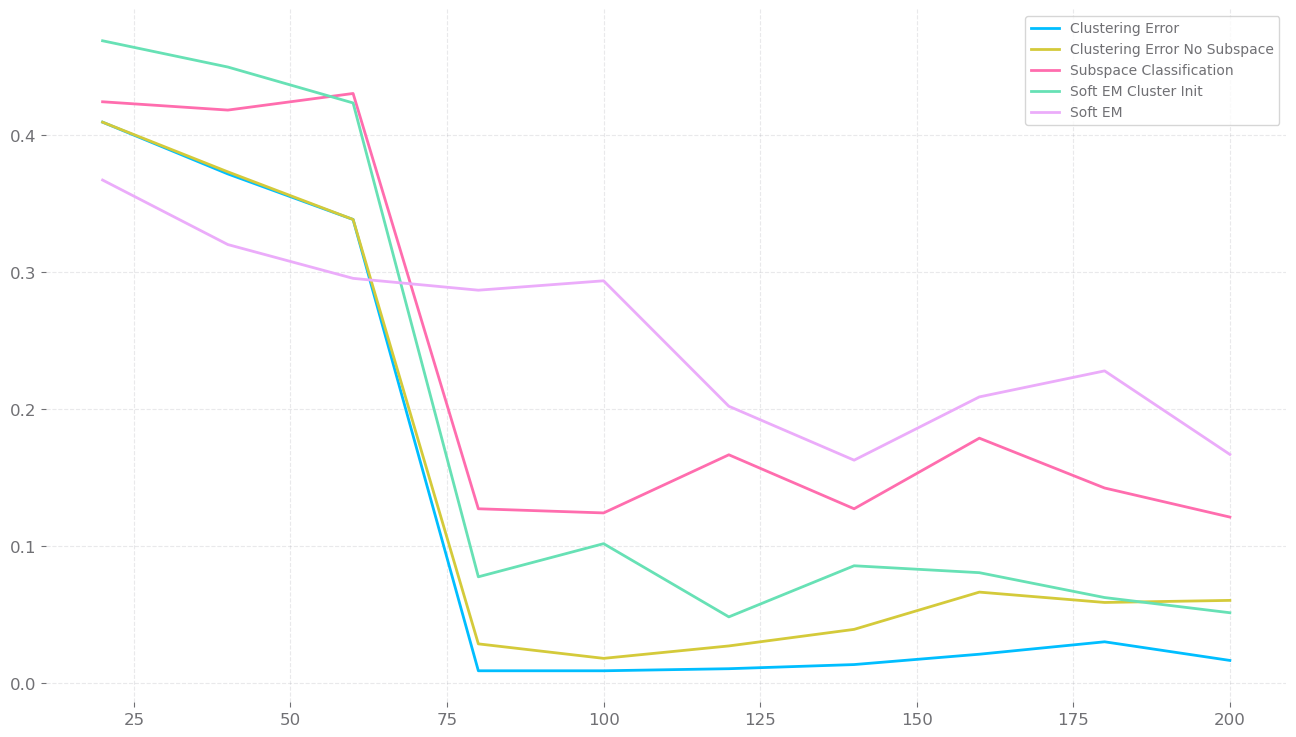

In [135]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.array(clusterAccs), label='Clustering Error')
plt.plot(horizons, 1-np.array(clusterAccsNoProjs), label='Clustering Error No Subspace')

plt.plot(horizons, 1-np.array(classAccs), label='Subspace Classification')

'''
plt.plot(horizons, 1-np.array(hardClustEMAccs),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.array(hardEMAccs),
        label='Hard EM')
'''

plt.plot(horizons, 1-np.array(softClustEMAccs),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.array(softEMAccs),
        label='Soft EM')

plt.legend()

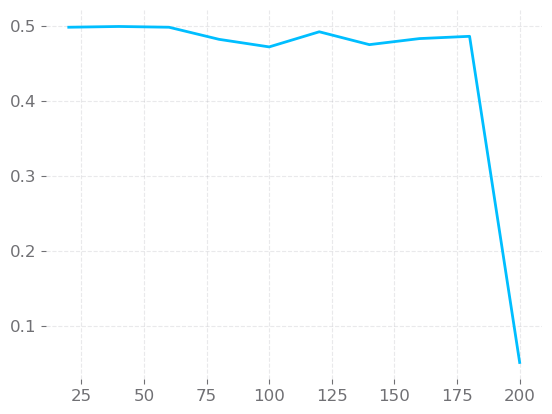

In [124]:
plt.plot(horizons, 1-np.array([np.max([np.mean(np.argmax(i[0],0)==labels), 
                  np.mean(np.argmax(i[0],0)!=labels)]) for i in softClustEMs]),
         label='Soft EM Cluster Init')

In [127]:
[np.mean(j == labels) for j in np.array([i[0] for i in softClustEMs]).argmax(1)]

[0.49798387096774194,
 0.501008064516129,
 0.49798387096774194,
 0.5181451612903226,
 0.5282258064516129,
 0.49193548387096775,
 0.4747983870967742,
 0.5171370967741935,
 0.5141129032258065,
 0.05141129032258065]

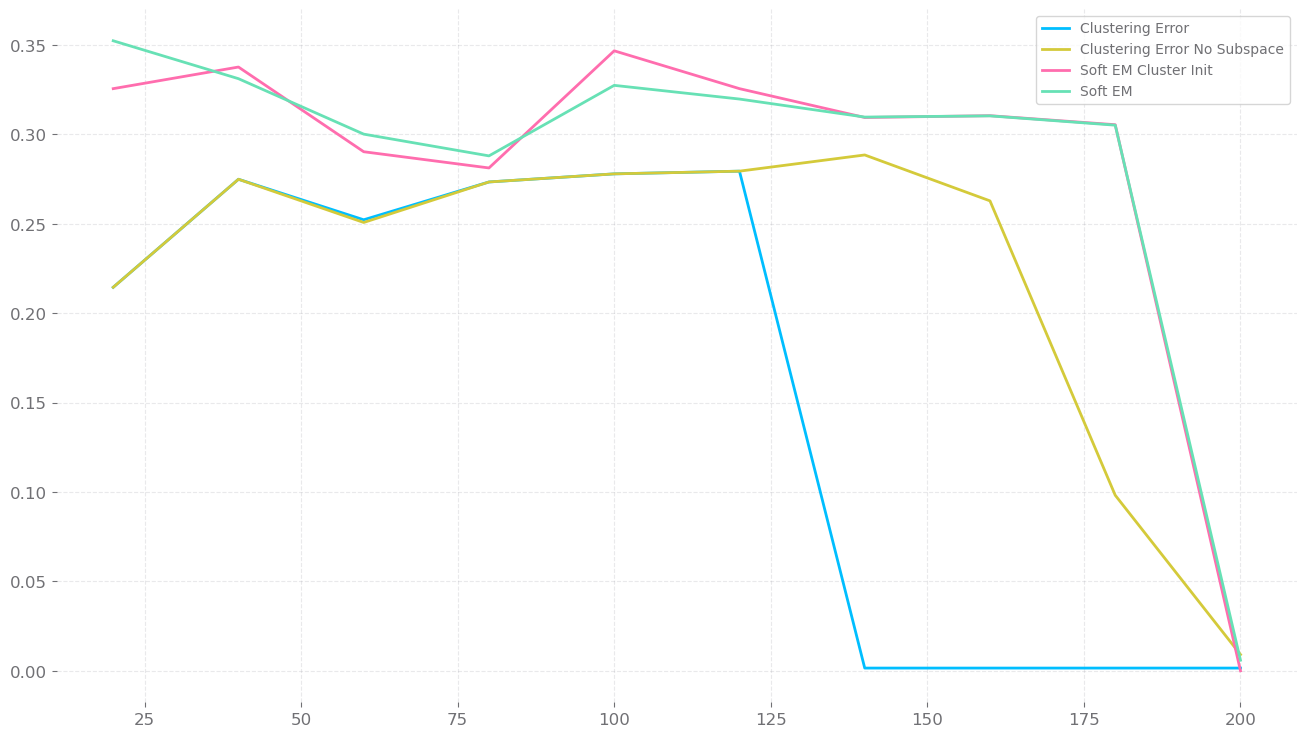

In [4]:
plt.figure(figsize=(16,9))
plt.plot(horizons, 1-np.array(clusterAccs), label='Clustering Error')
plt.plot(horizons, 1-np.array(clusterAccsNoProjs), label='Clustering Error No Subspace')
'''
plt.plot(horizons, 1-np.array(classAccs), label='Subspace Classification')
plt.plot(horizons, 1-np.array([np.max([np.mean(i[0]==labels), 
                  np.mean(i[0]!=labels)]) for i in hardClustEMs]),
         label='Hard EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in hardEMs[i][0]]) for i in range(len(hardEMs))]),
        label='Hard EM')
'''
plt.plot(horizons, 1-np.array([np.max([np.mean(np.argmax(i[0],0)==labels), 
                  np.mean(np.argmax(i[0],0)!=labels)]) for i in softClustEMs]),
         label='Soft EM Cluster Init')
plt.plot(horizons, 1-np.array([np.mean([np.max([np.mean(j.argmax(0)==labels), np.mean(j.argmax(0)!=labels)]) 
  for j in softEMs[i][0]]) for i in range(len(softEMs))]),
        label='Soft EM')
plt.legend()

In [85]:
expectclass, modelestimclass, loglikclass = em(maxapos, 
                            Phat_ksa, states, actions, 
                        nextstates, labels=labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, max_iter=100,
                                               permute=False, permutation=permutation,
                                               checkin=1, hard=True)

iteration 1 diff 219.14279581992716
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 2 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 3 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 4 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 5 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 6 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 7 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 8 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 9 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
iteration 10 diff 0.0
992 992
accuracy: 0.9395161290322581
-158443.87642185992
log-likelihood: -158443.87642185992


In [117]:
Ptrunc = np.zeros((K, nStates, nActions, nStates))
for u in tqdm(range(K)):
    for s in range(nStates):
        for a in range(nActions):
            for sp in range(nStates):
                Ptrunc[u, idx_to_trunc(s), a, idx_to_trunc(sp)] += P.transpose(0,2,1,3)[u, s, a, sp]

100%|██████████| 2/2 [00:00<00:00,  2.11it/s]


In [88]:
normprobs = np.exp(mleprobs-np.max(mleprobs))
regprobs = 0.8*(normprobs)/np.nansum(np.abs(normprobs), 0) + 0.1*np.ones(mleprobs.shape)
expectclasssoft, modelestimclasssoft, loglikclasssoft = em(regprobs, 
                            Phat_ksa, states, actions, 
                        nextstates, labels, 
                        K=2, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 1, permute=False, permutation=permutation, checkin=1, hard=False)

iteration 1 diff 902.6985444463013
992 992
accuracy: 0.8850806451612904
-886518.5876762507
iteration 2 diff 898.7744546241128
992 992
accuracy: 1.0
-158933.26282156003
iteration 3 diff 262.0420420306183
992 992
accuracy: 1.0
-156091.77859972478
iteration 4 diff 316.47410281703657
992 992
accuracy: 1.0
-156090.68229785652
iteration 5 diff 55.35555552864855
992 992
accuracy: 1.0
-156090.68229785652
iteration 6 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 7 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 8 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 9 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
iteration 10 diff 0.0
992 992
accuracy: 1.0
-156090.68229785652
log-likelihood: -156090.68229785652


In [89]:
unifs = np.random.uniform(size=len(dataset))
randlabsoft = np.vstack([unifs, 1-unifs])
randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
randlabsoft, randmodelsoft, loglikrandsoft = em(randlabsoft, randmodelsoft,
   states[sz:], actions[sz:], nextstates[sz:], labels[sz:], 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, min_iter = 20, reg = 0, permute=True, permutation=True, checkin=1, hard=False)

iteration 1 diff 303.67803261481635
662 662
accuracy: 0.6661631419939577
-106004.2150536633
iteration 2 diff 88.85210336160041
662 662
accuracy: 0.9516616314199395
-105923.98173374307
iteration 3 diff 226.18172385281557
662 662
accuracy: 0.9788519637462235
-103798.73280693352
iteration 4 diff 167.88232418890323
662 662
accuracy: 0.9879154078549849
-103492.02305564527
iteration 5 diff 185.17964475977345
662 662
accuracy: 0.9909365558912386
-103490.25558164774
iteration 6 diff 19.488909581139758
662 662
accuracy: 0.9924471299093656
-103482.78125795255
iteration 7 diff 11.302521796352703
662 662
accuracy: 0.9939577039274925
-103479.7842277346
iteration 8 diff 14.447802779639565
662 662
accuracy: 0.9954682779456193
-103494.53606567462
iteration 9 diff 7.523305447976231
662 662
accuracy: 0.9954682779456193
-103489.15595104265
iteration 10 diff 9.866920475853298
662 662
accuracy: 0.9969788519637462
-103493.5191028165
iteration 11 diff 4.059558400784289
662 662
accuracy: 0.9969788519637462
-1

In [ ]:
labelsemsoft = []
logliksemsoft = []
for i in tqdm(range(30)):
    unifs = np.random.uniform(size=len(dataset))
    randlabsoft = np.vstack([unifs, 1-unifs])
    randmodelsoft = getModelEstim(randlabsoft, states, actions, nextstates,
                              K, nStates, nActions, hard=False)
    randlabsoft, randmodelsoft, loglikrand = em(randlabsoft, randmodelsoft,
   states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=False)
    labelsemsoft.append(randlabsoft)
    logliksemsoft.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)], 
            logliksemsoft)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)]))
plt.ticklabel_format(style='plain',useOffset=False)
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Soft EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in np.array(labelsemsoft).argmax(axis=1)])
plt.show()

 77%|███████▋  | 23/30 [00:15<00:04,  1.62it/s]

100%|██████████| 30/30 [00:19<00:00,  1.55it/s]

0.9164463141025639
0.9213241185897436
0.9365985576923077


(array([ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

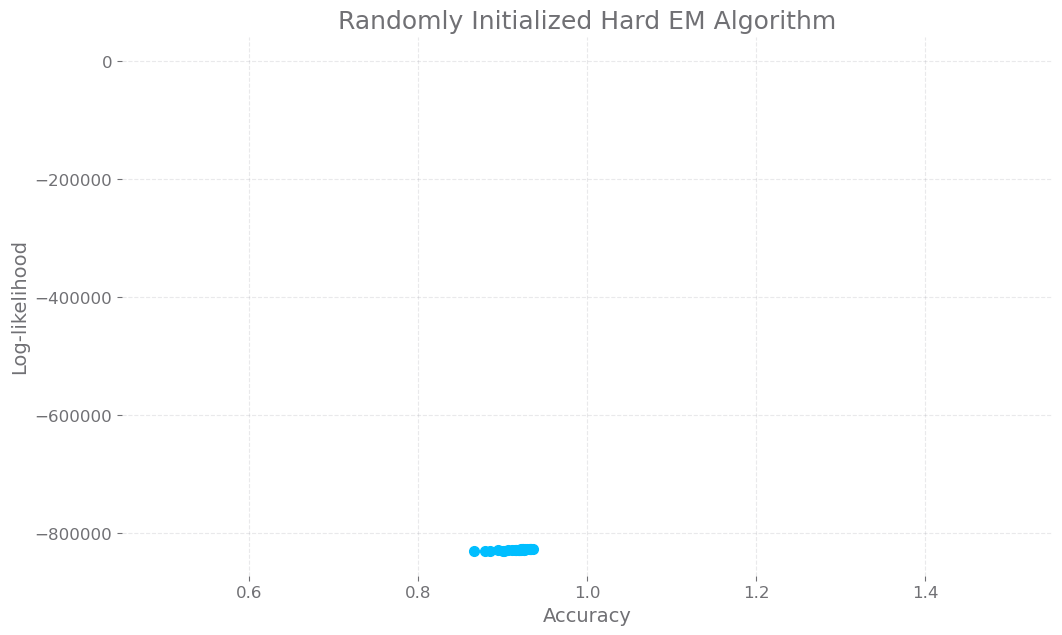

In [30]:
labelsem = []
logliksem = []
for i in tqdm(range(30)):
    randlabs = np.random.binomial(1, 0.5, size=len(dataset)).astype(int)
    randmodel = getModelEstim(randlabs, states, actions, nextstates,
                              K, nStates, nActions, hard=True)
    randlabs, randmodel, loglikrand = em(randlabs, randmodel,
       states, actions, nextstates, labels, 
                        K=K, nStates=nStates, nActions=nActions,
                        prior = priorclass, reg = 0, permute=True, permutation=permutation, checkin=1, verbose=False, hard=True)
    labelsem.append(randlabs)
    logliksem.append(loglikrand)
plt.figure(figsize=(12,7))
plt.scatter([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem], logliksem)
print(np.mean([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.median([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
print(np.max([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem]))
plt.xlabel('Accuracy')
plt.ylabel('Log-likelihood')
plt.title('Randomly Initialized Hard EM Algorithm')
plt.show()
plt.hist([max(np.mean(i == labels), np.mean(i != labels)) for i in labelsem])
plt.show()